<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: рекомендательные системы</center></h2>

# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

# Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import math

Загрузим данные и проведем предобраотку данных как на семинаре.

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"daniilburakov","key":"f14b597ad5167832bca8d34ab53af291"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d gspmoreira/articles-sharing-reading-from-cit-deskdrop
!unzip articles-sharing-reading-from-cit-deskdrop.zip -d articles

 85% 7.00M/8.20M [00:00<00:00, 72.8MB/s]
100% 8.20M/8.20M [00:00<00:00, 80.1MB/s]
Archive:  articles-sharing-reading-from-cit-deskdrop.zip
  inflating: articles/shared_articles.csv  
  inflating: articles/users_interactions.csv  


In [4]:
articles_df = pd.read_csv("articles/shared_articles.csv")
articles_df = articles_df[articles_df["eventType"] == "CONTENT SHARED"]
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [5]:
interactions_df = pd.read_csv("articles/users_interactions.csv")
interactions_df.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [6]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [7]:
# зададим словарь определяющий силу взаимодействия
event_type_strength = {
   "VIEW": 1.0,
   "LIKE": 2.0, 
   "BOOKMARK": 2.5, 
   "FOLLOW": 3.0,
   "COMMENT CREATED": 4.0,  
}

interactions_df["eventStrength"] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.

In [8]:
users_interactions_count_df = (
    interactions_df
    .groupby(["personId", "contentId"])
    .first()
    .reset_index()
    .groupby("personId").size())
print("# users:", len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[["personId"]]
print("# users with at least 5 interactions:",len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [9]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [10]:
print(f"# interactions before: {interactions_df.shape}")
print(f"# interactions after: {interactions_from_selected_users_df.shape}")

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье и сглажиываем полученный результат, взяв от него логарифм.

In [11]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(["personId", "contentId"]).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(["personId", "contentId"])
)
interactions_full_df["last_timestamp"] = (
    interactions_from_selected_users_df
    .groupby(["personId", "contentId"])["timestamp"].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [12]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print(f"# interactions on Train set: {len(interactions_train_df)}")
print(f"# interactions on Test set: {len(interactions_test_df)}")

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [13]:
interactions = (
    interactions_train_df
    .groupby("personId")["contentId"].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={"contentId": "true_train"})
    .set_index("personId")
)

interactions["true_test"] = (
    interactions_test_df
    .groupby("personId")["contentId"].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), "true_test"] = [
    "" for x in range(len(interactions.loc[pd.isnull(interactions.true_test), "true_test"]))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


# Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [14]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 15.4 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705367 sha256=0003578c91c605633039c9d1d3c2ee1d3196932e14eb12a6741285f00b95c91c
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [15]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

## Задание 1 (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

In [16]:
user_id_mapping = {id:i for i, id in enumerate(interactions_full_df['personId'].unique())}
item_id_mapping = {id:i for i, id in enumerate(interactions_full_df['contentId'].unique())}

train_user_data = interactions_train_df['personId'].map(user_id_mapping)
train_movie_data = interactions_train_df['contentId'].map(item_id_mapping)

test_user_data = interactions_test_df['personId'].map(user_id_mapping)
test_movie_data = interactions_test_df['contentId'].map(item_id_mapping)

In [17]:
from scipy.sparse import coo_matrix
shape = (len(user_id_mapping), len(item_id_mapping))
train_matrix = coo_matrix((interactions_train_df['eventStrength'].values, (train_user_data.astype(str), train_movie_data.astype(str))), shape=shape)
test_matrix = coo_matrix((interactions_test_df['eventStrength'].values, (test_user_data.astype(str), test_movie_data.astype(str))), shape=shape)

## Задание 2 (1 балл)

Обучите модель LightFM с `loss="warp"` и посчитайте *precision@10* на тесте.

In [18]:
model = LightFM(loss='warp')
model.fit(train_matrix, epochs = 20)

In [19]:
test_precision = precision_at_k(model, test_matrix, k=10).mean()
print("precision@10:", test_precision)

precision@10: 0.0045824847


## Задание 3 (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количесвто статей на размер признакового описание и обучите LightFM с `loss="warp"` и посчитайте precision@10 на тесте.

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
feat = vectorizer.fit_transform(articles_df['text'])

In [80]:
model = LightFM(loss='warp')
model.fit(train_matrix, item_features=feat, epochs=20)

test_precision = precision_at_k(model, test_matrix, item_features=feat, k=10, train_interactions=train_matrix).mean()
print(f"Precision: {test_precision}")

Precision: 0.006415478885173798


## Задание 4 (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к номральной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

In [81]:
import spacy

nlp = spacy.load('en_core_web_sm')
feat = articles_df['text'].apply(lambda x: nlp(x))

In [82]:
feat1 = feat.apply(lambda x: str(x))

In [83]:
vectorizer = TfidfVectorizer()
feat = vectorizer.fit_transform(feat1)

In [85]:
model = LightFM(loss='warp')
model.fit(train_matrix, item_features=feat, epochs=20)

test_precision = precision_at_k(model, test_matrix, item_features=feat, k=10, train_interactions=train_matrix).mean()
print(f"Precision: {test_precision}")

Precision: 0.006822810973972082


Улучшилось ли качество предсказания?
МОдель улучшила свои предсказания на 0.0004 по метрике precision@10

## Задание 5 (2 балла)

Подберите гиперпараметры модели LightFM (`n_components` и др.) для улучшения качества модели.

In [34]:
n_components = np.arange(10, 25, 5)
epochs = np.arange(10, 50, 10)
max = 0
for n_component in n_components:
  for epoch in epochs:
    model = LightFM(loss='warp', no_components = n_component)
    model.fit(train_matrix, item_features=feat, epochs= epoch)
    test_precision = precision_at_k(model, test_matrix, item_features=feat, k=10, train_interactions=train_matrix).mean()
    if(max < test_precision):
      max = test_precision
      best_n_components = n_component
      best_epochs = epoch

print(f"Best precision: {max}, best n_components = {best_n_components}m best epochs = {best_epochs}")

Best precision: 0.008553971536457539, best n_components = 20m best epochs = 40


## Бонусное задание (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмеддингов и сравните результаты с предыдущими.

In [65]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 25.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=77810b34628a0ee4d5abe691ee811a8258fedcc2d0398a908c988ffa0d2d108c
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


In [70]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-v2')

tokenized_texts = model.encode(articles_df['text'].to_list())

In [77]:
from scipy.sparse import coo_matrix
feat2 = coo_matrix(tokenized_texts)

In [78]:
model = LightFM(loss='warp')
model.fit(train_matrix, item_features=feat2, epochs=20)

test_precision = precision_at_k(model, test_matrix, item_features=feat2, k=10, train_interactions=train_matrix).mean()
print(f"Precision: {test_precision}")

Precision: 0.001731160911731422


Итоги работы с LightFM:

Модель крайне не робастная, при одних и тех же данных при одинаковых прогонах результат по метрике precision может отличаться в разы. 
Крайняя чувствительность к seedу. Прогоняем на одних и тех же данных и ждем ЧУДА.

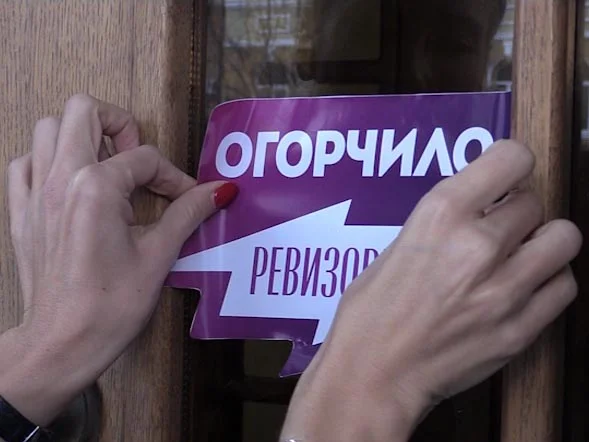